In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras import layers as L
from keras.models import Sequential

Using TensorFlow backend.


## Loading data

In [257]:
data = np.load("data/next.npy")

First thing we need to do is to normalize data into $[-1, 1]$. We can simply use a $\tanh$ function.

In [250]:
data = np.tanh(data)

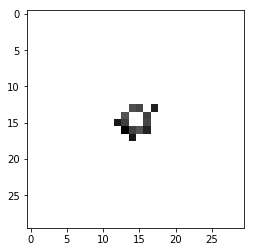

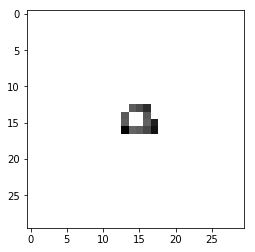

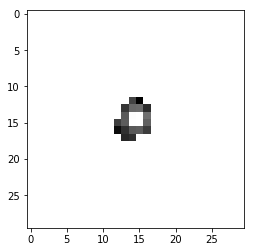

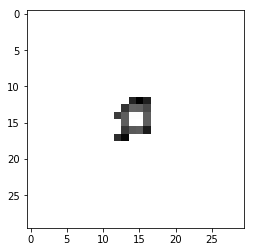

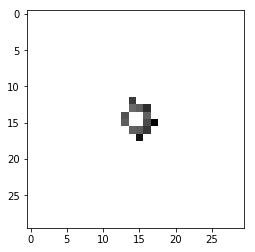

In [244]:
for im in data[:5]:
    plt.imshow(im, cmap="gray")
    plt.show()

In [7]:
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))

The next thing we do is construct a NN configuration. In generator we usually use deconv layers.

In [19]:
gen = Sequential()
CODE_SIZE = 100

gen.add(L.InputLayer([CODE_SIZE], name="Noise"))
gen.add(L.Dense(activation="relu", units=7*7))

gen.add(L.Reshape((7, 7, 1)))
gen.add(L.Deconv2D(128,kernel_size=5,activation='relu'))
gen.add(L.Deconv2D(128,kernel_size=5,activation='relu'))
gen.add(L.Deconv2D(64,kernel_size=5,activation='relu'))
gen.add(L.Deconv2D(64,kernel_size=5,activation='relu'))
gen.add(L.Deconv2D(32,kernel_size=4,activation='relu'))
gen.add(L.Deconv2D(32,kernel_size=4,activation='relu'))
gen.add(L.Deconv2D(16,kernel_size=4,activation='relu'))

gen.add(L.Conv2D(1,kernel_size=3,activation="tanh"))

In [20]:
feedback_shape = gen.output_shape[1:]

feedback_shape

(30, 30, 1)

Discriminator is a simple classifier convolutional neural network.

In [21]:
discriminator = Sequential()

discriminator.add(L.InputLayer(gen.output_shape[1:]))
discriminator.add(L.Conv2D(32,kernel_size=3,activation='relu'))
discriminator.add(L.MaxPool2D(pool_size=(2,2)))
discriminator.add(L.Conv2D(32,kernel_size=3,activation='relu'))
discriminator.add(L.Conv2D(64,kernel_size=3,activation='relu'))
discriminator.add(L.Conv2D(64,kernel_size=3,activation='relu'))
discriminator.add(L.MaxPool2D(pool_size=(2,2)))
discriminator.add(L.Conv2D(128,kernel_size=3,activation='relu'))
discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

In [22]:
discriminator.output_shape

(None, 2)

Computing losses

In [23]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(feedback_shape))

diff_real = discriminator(real_data)

generated_data = gen(noise)
diff_generated = discriminator(generated_data)

d_loss = -tf.reduce_mean(diff_real[:,1] + diff_generated[:,0])

d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss, var_list=discriminator.trainable_weights)

g_loss = -tf.reduce_mean(diff_generated[:,1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=gen.trainable_weights)

In [24]:
s.run(tf.global_variables_initializer())

In [25]:
def sample_noise_batch(bsize):
    noise =np.random.normal(size=(bsize, CODE_SIZE)).astype('float32') 
    return noise

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs].reshape((-1, 30, 30, 1))

def sample_images(nrow,ncol, sharp=False):
    images = gen.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            print(images[i].shape)
            plt.imshow(images[i].reshape(30,30),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(30,30),cmap="gray")
    plt.show()
    return images

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(gen.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()
    
def sample_many_images(how_many):
    images = gen.predict(sample_noise_batch(bsize=how_many)).reshape(-1, 30, 30)
    return images

(30, 30, 1)


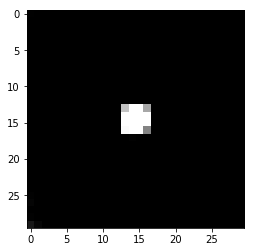

array([[[[-0.98527551],
         [-0.99979019],
         [-0.99999881],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-0.99999058],
         [-0.99814063]],

        [[-0.99933809],
         [-0.99999934],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1.        ],
         [-1. 

In [59]:
sample_images(1,1, True)

epoch 300
(30, 30, 1)


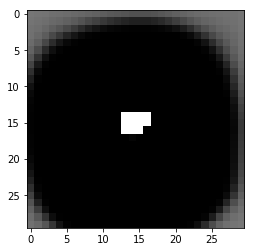

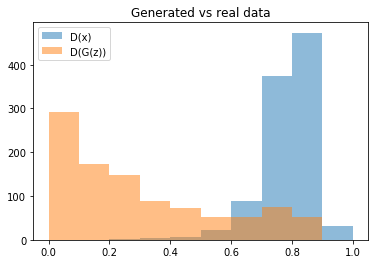

In [ ]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch % 100==0:
        display.clear_output()
        print("epoch", epoch)
        sample_images(1,1,True)
        sample_probas(1000)

In [229]:
epoch

49999

In [224]:
ims = sample_many_images(10000)

What we can see here is that distributions of real data energy and the generated one do not match: generated data is shifted and tails decrease faster.

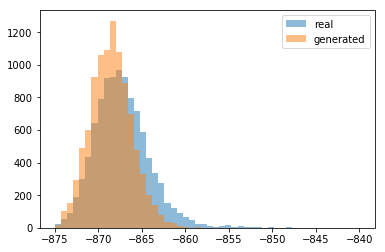

In [230]:
plt.hist(np.sum(data, axis=(1,2)), bins=50,range=(-875,-840), alpha=0.5, label="real")
plt.hist(np.sum(ims, axis=(1,2)), bins=50, range=(-875,-840), alpha=0.5, label="generated")
plt.legend()
plt.show()

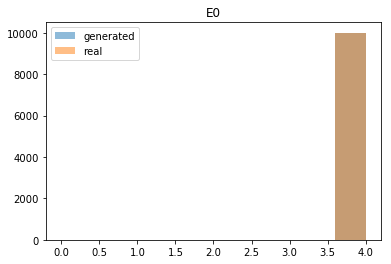

In [235]:
plt.title("E0")
plt.hist(np.sum(ims[:,14:16, 14:16], axis=(1,2)),range=(0,4),alpha=0.5, label="generated")
plt.hist(np.sum(data[:,14:16, 14:16], axis=(1,2)),range=(0,4), alpha=0.5, label="real")
plt.legend()
plt.show()

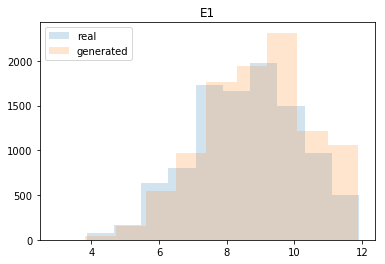

In [236]:
support_E1_gen = np.sum(ims[:, 13:17, 13:17],axis=(1,2))- np.sum(ims[:, 14:16, 14:16],axis=(1,2))
support_E1_real = np.sum(data[:, 13:17, 13:17],axis=(1,2))- np.sum(data[:, 14:16, 14:16],axis=(1,2))
plt.title("E1")
plt.hist(support_E1_real,alpha=0.2,label="real")
plt.hist(support_E1_gen,alpha=0.2,label="generated")
plt.legend()
plt.show()

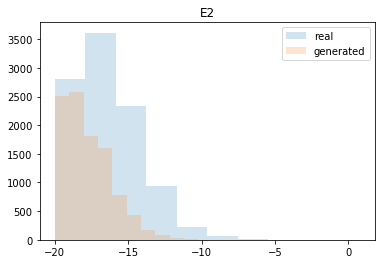

In [155]:
support_E2_gen = np.sum(ims[:, 12:18, 12:18],axis=(1,2))- np.sum(ims[:, 13:17, 13:17],axis=(1,2))
support_E2_real = np.sum(data[:, 12:18, 12:18],axis=(1,2))- np.sum(data[:, 13:17, 13:17],axis=(1,2))
plt.title("E2")
plt.hist(support_E2_real,alpha=0.2,label="real")
plt.hist(support_E2_gen,alpha=0.2,label="generated")
plt.legend()
plt.show()

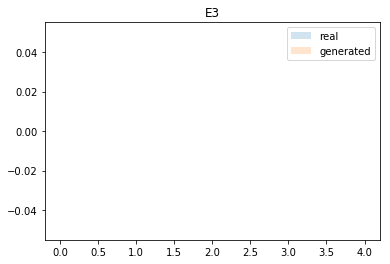

In [149]:
support_E3_gen = np.sum(ims[:, 11:19, 11:19],axis=(1,2))- np.sum(ims[:, 13:17, 13:17],axis=(1,2))
support_E3_real = np.sum(data[:, 11:19, 11:19],axis=(1,2))- np.sum(data[:, 13:17, 13:17],axis=(1,2))
plt.title("E3")
plt.hist(support_E3_real,alpha=0.2,range=(0,4),label="real")
plt.hist(support_E3_gen,alpha=0.2, range=(0,4),label="generated")
plt.legend()
plt.show()

Now let's try to show a histogram in the original scale.

In [263]:
data = np.load("data/next.npy")
ims = sample_many_images(10000)
ims = np.arctanh(ims)

data[np.isinf(data)] = 0
ims[np.isinf(ims)] = 0

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


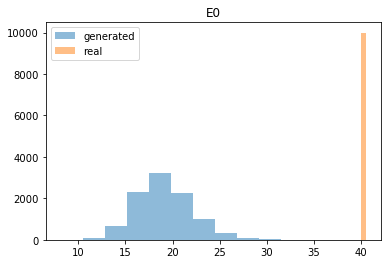

In [265]:
plt.title("E0")
plt.hist(np.sum(ims[:,14:16, 14:16], axis=(1,2)),alpha=0.5, label="generated")
plt.hist(np.sum(data[:,14:16, 14:16], axis=(1,2)), alpha=0.5, label="real")
plt.legend()
plt.show()

As we can see, even if distributions $\mathrm{E}_0$ match each other perfectly in tanh scale, they might be significantly different in the original scale.

## Summary

 * GANs do not learn on the original dataset: it needs to be normalized
 * GANs generate images from the middle of the shifted distribution. Variance is very low.
 * Historgarms in the original scale can not be showed due to `inf`'s. Denormalizing generated data to the original scale give no result due to numerical instability.

## My ideas

 * We can try to train a GAN with on the original scale, but replace -`inf`'s by zeros